### Imports

In [1]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [2]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle

### Data

In [3]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, 1024)]

In [4]:
data = pd.read_csv('data/sacharose_1000/all.csv', sep = '\t').iloc[:,:-1]

In [5]:
data.columns = names

In [6]:
def load_spectrum(data, moment_of_time):
    ppm = data['ppm']
    intensity = data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    return sp

### Components

In [7]:
sacharose = pd.read_csv('data/sacharose_1000/sucrose.csv', sep = '\t', header=None).iloc[:,:-1]
glucose = pd.read_csv('data/sacharose_1000/glucose.csv', sep = '\t', header=None).iloc[:,:-1]
fructose = pd.read_csv('data/sacharose_1000/fructose.csv', sep = '\t', header=None).iloc[:,:-1]

all_substances = [sacharose, glucose, fructose]

In [8]:
spectra = []
for sub in all_substances:
    ppm = sub[0]
    ints = sub[1]
    sp = NMRSpectrum(confs = list(zip(ppm, ints)))
    sp.trim_negative_intensities()
    sp.normalize()
    spectra.append(sp)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


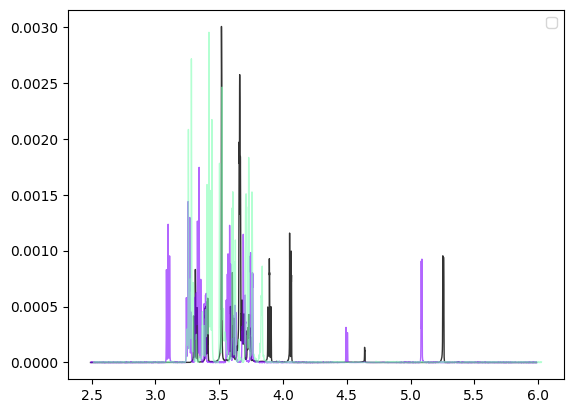

In [9]:
NMRSpectrum.plot_all(spectra, profile=True)

### Estimation

In [10]:
kappa = 0.25
kappa_th = 0.5

In [11]:
proportions_in_times = []
noise_proportions_in_times = []

sp1 = load_spectrum(data, 1)
sp1.trim_negative_intensities()
sp1.normalize()

for i in range(1, 1024):
    print('This is timepoint '+str(i)+'.\n')
    mix = load_spectrum(data, i)
    estimation = estimate_proportions(mix, spectra, what_to_compare='area', 
                                      solver=pulp.GUROBI(msg=False),
                                     MTD=kappa, MTD_th=kappa_th)
        
    proportions_in_times.append(estimation['proportions'])
    noise_proportions_in_times.append(estimation['proportion_of_noise_in_components'])
    
    print('Proportions:\n')
    print(estimation['proportions'])
    print('\n')
    print('Proportion_of_noise_in_components:\n')
    print(estimation['proportion_of_noise_in_components'])
    print('\n')

This is timepoint 1.

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.6199666672087821, 0.15510684707189498, 0.12296888974549962]


Proportion_of_noise_in_components:

0.0


This is timepoint 2.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.62355789421466, 0.14698375016598234, 0.1318305306294513]


Proportion_of_noise_in_components:

0.0


This is timepoint 3.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.6249096129362913, 0.16695185728978726, 0.10353603312064392]


Proportion_of_noise_in_components:

0.0


This is timepoint 4.

The mixture's spectrum cannot contain negative intensit

Proportions:

[0.6212537359569076, 0.16885941225714612, 0.10709595007759592]


Proportion_of_noise_in_components:

0.0


This is timepoint 28.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.6213288676820679, 0.14715086533809588, 0.13411105932206507]


Proportion_of_noise_in_components:

0.0


This is timepoint 29.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.6246166472991461, 0.14746814512406423, 0.12876038657222624]


Proportion_of_noise_in_components:

4.4706256423556646e-05


This is timepoint 30.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.6217850871643

Proportions:

[0.6129248669029936, 0.16545817959662112, 0.12470088368289726]


Proportion_of_noise_in_components:

0.0


This is timepoint 54.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.6213199520545785, 0.18825090367647043, 0.0848486552674977]


Proportion_of_noise_in_components:

0.0


This is timepoint 55.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.6142773372382402, 0.18463639322449446, 0.10218737990419552]


Proportion_of_noise_in_components:

0.0


This is timepoint 56.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.6161936708585581, 0.1869814125602

Proportions:

[0.6111337348836535, 0.20718932155840952, 0.0818381389896135]


Proportion_of_noise_in_components:

0.0


This is timepoint 80.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.6106911525215463, 0.20877168934313492, 0.08038081557245584]


Proportion_of_noise_in_components:

0.0


This is timepoint 81.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.6076456349672883, 0.20592866035576046, 0.09096099513991578]


Proportion_of_noise_in_components:

0.0


This is timepoint 82.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5933240625927086, 0.1784017371127

Proportions:

[0.6037440836269866, 0.21353219066653203, 0.0847475430577201]


Proportion_of_noise_in_components:

0.0


This is timepoint 106.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.60064238839104, 0.2216231471782297, 0.07906039428850874]


Proportion_of_noise_in_components:

0.0


This is timepoint 107.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.6019656011347906, 0.21158139226420394, 0.08834275047791149]


Proportion_of_noise_in_components:

0.0


This is timepoint 108.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5983373853812674, 0.1974642054469

Proportions:

[0.591643138594645, 0.22879557141716272, 0.08427175905746048]


Proportion_of_noise_in_components:

0.0


This is timepoint 132.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5910428959132961, 0.22850658634377594, 0.0821383479091687]


Proportion_of_noise_in_components:

0.0


This is timepoint 133.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5824044720444357, 0.2213156328102407, 0.10298149746287542]


Proportion_of_noise_in_components:

0.0


This is timepoint 134.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5970654070278002, 0.222238431619

Proportions:

[0.5727405620556095, 0.24420428960925836, 0.08476395417085453]


Proportion_of_noise_in_components:

0.0


This is timepoint 158.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.557309311944404, 0.22979444780371897, 0.12452103038040668]


Proportion_of_noise_in_components:

0.0


This is timepoint 159.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5771533036425158, 0.2410697053078606, 0.08657978970709883]


Proportion_of_noise_in_components:

0.0


This is timepoint 160.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.563851706955959, 0.234742374721

Proportions:

[0.5574878154586274, 0.24798790163063375, 0.10260591654779744]


Proportion_of_noise_in_components:

0.0


This is timepoint 184.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5595939024393412, 0.25515145373742165, 0.09290652128170755]


Proportion_of_noise_in_components:

0.0


This is timepoint 185.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5595386404962035, 0.2541535377288924, 0.09339519847013417]


Proportion_of_noise_in_components:

0.0


This is timepoint 186.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5509207532730697, 0.2463877781

Proportions:

[0.5434144000495781, 0.25494131547558335, 0.1151731397479012]


Proportion_of_noise_in_components:

0.0


This is timepoint 210.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5468049004140291, 0.2667607879146949, 0.08777429537574256]


Proportion_of_noise_in_components:

0.0


This is timepoint 211.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5478019287423244, 0.2686221041521713, 0.08580018430710466]


Proportion_of_noise_in_components:

0.0


This is timepoint 212.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5461181512143486, 0.250013384944

Proportions:

[0.5330450350055261, 0.26773643455366575, 0.11330867975596541]


Proportion_of_noise_in_components:

0.0


This is timepoint 236.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.531991958860653, 0.2725998827943264, 0.09909647533106329]


Proportion_of_noise_in_components:

0.0


This is timepoint 237.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5316851557754814, 0.2728379712740415, 0.10522583829441122]


Proportion_of_noise_in_components:

0.0


This is timepoint 238.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5311869980347368, 0.276547151493

Proportions:

[0.5144390069685316, 0.2706513237856095, 0.13174287859784775]


Proportion_of_noise_in_components:

0.0


This is timepoint 262.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5234823437943316, 0.2774922961225137, 0.10496424220466395]


Proportion_of_noise_in_components:

0.0


This is timepoint 263.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5147637559066056, 0.27783301149383555, 0.11777874635109385]


Proportion_of_noise_in_components:

0.0


This is timepoint 264.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5199167184723283, 0.27734377612

Proportions:

[0.4956848466951474, 0.27871363707011126, 0.14301380709943204]


Proportion_of_noise_in_components:

0.0


This is timepoint 288.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5035462952594486, 0.2814984361667474, 0.12797373693967432]


Proportion_of_noise_in_components:

0.0


This is timepoint 289.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5049919698351034, 0.2848886530077662, 0.12275731798079242]


Proportion_of_noise_in_components:

0.0


This is timepoint 290.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.5051933681269366, 0.28090014728

Proportions:

[0.4910053310448503, 0.2875784436606934, 0.135850893908113]


Proportion_of_noise_in_components:

0.0


This is timepoint 314.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.49605959678112194, 0.2890016062124139, 0.12494546005411476]


Proportion_of_noise_in_components:

0.0


This is timepoint 315.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.4955584538501837, 0.28838293027719314, 0.12143006452465427]


Proportion_of_noise_in_components:

0.0


This is timepoint 316.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.49482163642694577, 0.28630076548

Proportions:

[0.4813787720893169, 0.2889574552598035, 0.1420677593717838]


Proportion_of_noise_in_components:

0.0


This is timepoint 340.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.4779042307445938, 0.2891312210144095, 0.1432681005080358]


Proportion_of_noise_in_components:

0.0


This is timepoint 341.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.48063026314234086, 0.29382751937342566, 0.13885488185452236]


Proportion_of_noise_in_components:

0.0


This is timepoint 342.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.466134893990829, 0.2753429217438

Proportions:

[0.4695873596332157, 0.2943715300494892, 0.1460897277921004]


Proportion_of_noise_in_components:

0.0


This is timepoint 366.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.46912075550589494, 0.2946942840684299, 0.14712407265909364]


Proportion_of_noise_in_components:

0.0


This is timepoint 367.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.4653342980348611, 0.29549292792739607, 0.15155361253137384]


Proportion_of_noise_in_components:

0.0


This is timepoint 368.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.46283693919882374, 0.2935920694

Proportions:

[0.4476728732704259, 0.2954019739827731, 0.17515217986296636]


Proportion_of_noise_in_components:

0.0


This is timepoint 392.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.4573231617967423, 0.29146810763548736, 0.17492252169896524]


Proportion_of_noise_in_components:

0.0


This is timepoint 393.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.4568403066050197, 0.2989302987514339, 0.15477246215571722]


Proportion_of_noise_in_components:

0.0


This is timepoint 394.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.440819267140576, 0.282908723118

Proportions:

[0.4434883346858704, 0.3027720497845093, 0.16596616000609368]


Proportion_of_noise_in_components:

0.0


This is timepoint 418.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.43368508023490754, 0.28902616266159536, 0.20733627610943778]


Proportion_of_noise_in_components:

2.0551734988829778e-05


This is timepoint 419.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.4327723912284524, 0.29328069430200093, 0.20193464877838815]


Proportion_of_noise_in_components:

6.961645369229845e-06


This is timepoint 420.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportio

Proportions:

[0.425907141222959, 0.3051195172536673, 0.18478292427314316]


Proportion_of_noise_in_components:

0.0


This is timepoint 443.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.38940612537571023, 0.27057421562894385, 0.2927746154052006]


Proportion_of_noise_in_components:

0.00015189736995970766


This is timepoint 444.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.4219326603493357, 0.29769244591030597, 0.2089028687856096]


Proportion_of_noise_in_components:

1.0588746994804467e-05


This is timepoint 445.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions

Proportions:

[0.4278613408734513, 0.3040573784818732, 0.19038852508713988]


Proportion_of_noise_in_components:

0.0


This is timepoint 468.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.40324448496156506, 0.28907684854194665, 0.24413144745942267]


Proportion_of_noise_in_components:

7.697930593520784e-05


This is timepoint 469.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.3777434028677245, 0.27531109472350984, 0.29829204433518997]


Proportion_of_noise_in_components:

0.00012307834001715998


This is timepoint 470.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportio

Proportions:

[0.4010967962085784, 0.29824998239301176, 0.23358915740185612]


Proportion_of_noise_in_components:

1.749826488340477e-05


This is timepoint 493.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.3925813782044023, 0.31233581238003666, 0.2194284539556441]


Proportion_of_noise_in_components:

6.489142403228875e-05


This is timepoint 494.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.43546753330406407, 0.3289631797446109, 0.14486741032773395]


Proportion_of_noise_in_components:

0.0


This is timepoint 495.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions

Proportions:

[0.40496778409903034, 0.32496982455715806, 0.1849141462471758]


Proportion_of_noise_in_components:

0.0


This is timepoint 519.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.38863448971628467, 0.30960790937969257, 0.23015538809633815]


Proportion_of_noise_in_components:

5.3218194993598116e-05


This is timepoint 520.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.3903300354681093, 0.3161998224648549, 0.21543969150076206]


Proportion_of_noise_in_components:

2.1354968042683963e-05


This is timepoint 521.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proporti

Proportions:

[0.38509966898002357, 0.3209624976087623, 0.21510496706796062]


Proportion_of_noise_in_components:

8.432720695382553e-06


This is timepoint 544.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.38899763003712445, 0.3259322763683592, 0.20151999154115863]


Proportion_of_noise_in_components:

0.0


This is timepoint 545.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.3707725923886923, 0.3198158812674565, 0.232699367728867]


Proportion_of_noise_in_components:

6.677445197194908e-05


This is timepoint 546.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:


Proportions:

[0.37462154783228985, 0.32679802198281127, 0.2159943516557539]


Proportion_of_noise_in_components:

0.0


This is timepoint 569.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.3420047030557842, 0.28412194636511623, 0.3269230025898071]


Proportion_of_noise_in_components:

0.00018176582535388183


This is timepoint 570.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.36228240624572594, 0.3264182202048539, 0.23242784007191875]


Proportion_of_noise_in_components:

1.5886999094187722e-05


This is timepoint 571.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportio

Proportions:

[0.361547177175331, 0.3308707787824124, 0.23168932306878523]


Proportion_of_noise_in_components:

2.309109461602866e-05


This is timepoint 594.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.3487547054010498, 0.330654182718179, 0.24344772892431657]


Proportion_of_noise_in_components:

3.115837426757636e-05


This is timepoint 595.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.35314540036851805, 0.3309959049911132, 0.23678242452232046]


Proportion_of_noise_in_components:

1.1226659844529865e-05


This is timepoint 596.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spect

Proportions:

[0.34367399587603475, 0.33464712597540835, 0.24565789881547115]


Proportion_of_noise_in_components:

2.1166068724121836e-05


This is timepoint 619.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.3466919150942876, 0.3341635455524735, 0.24223744260546512]


Proportion_of_noise_in_components:

1.7782612643562312e-05


This is timepoint 620.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.3493037227929188, 0.33521303935899516, 0.2350676593275594]


Proportion_of_noise_in_components:

9.294288289043577e-06


This is timepoint 621.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's s

Proportions:

[0.3267253860376764, 0.33976385435466816, 0.2571677315251594]


Proportion_of_noise_in_components:

4.3027194768239704e-05


This is timepoint 644.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.3251751683132804, 0.3385900750162627, 0.26125275303179724]


Proportion_of_noise_in_components:

7.803667585760179e-05


This is timepoint 645.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.32125776480163276, 0.3338455348266459, 0.27402896551206957]


Proportion_of_noise_in_components:

0.0001234739720545953


This is timepoint 646.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spe

Proportions:

[0.32611522889021644, 0.3425242458909875, 0.25690021565247767]


Proportion_of_noise_in_components:

5.919468623678032e-05


This is timepoint 669.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.31970576603987655, 0.34231645420808776, 0.2625980558919825]


Proportion_of_noise_in_components:

7.85846369368038e-05


This is timepoint 670.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.3243008267415862, 0.34247292996565265, 0.26068988739064985]


Proportion_of_noise_in_components:

4.6061476641161786e-05


This is timepoint 671.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's sp

Proportions:

[0.309247048945627, 0.34437936732980334, 0.2735779798716238]


Proportion_of_noise_in_components:

0.00012709566065530087


This is timepoint 694.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.31668266845815657, 0.347107678611081, 0.26218772237919646]


Proportion_of_noise_in_components:

7.886715730774362e-05


This is timepoint 695.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.3215662575363385, 0.35013343479001696, 0.25651850484833166]


Proportion_of_noise_in_components:

7.79761222055132e-05


This is timepoint 696.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spect

Proportions:

[0.3021924463253285, 0.3480671560567001, 0.27736267110538426]


Proportion_of_noise_in_components:

0.00012938909005595056


This is timepoint 719.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.30688092971148784, 0.3503462689237006, 0.2706630304455735]


Proportion_of_noise_in_components:

9.952327355596705e-05


This is timepoint 720.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.3047995807058867, 0.35169235126838366, 0.269826434688009]


Proportion_of_noise_in_components:

0.00011957122104840983


This is timepoint 721.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spec

Proportions:

[0.3129297045471954, 0.35816245297611166, 0.252700149573689]


Proportion_of_noise_in_components:

7.53198281578528e-05


This is timepoint 744.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.29934773148023347, 0.3548550790637229, 0.2736568071779344]


Proportion_of_noise_in_components:

0.00013592962882263924


This is timepoint 745.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.29799265925201235, 0.3557557551082609, 0.2733765624819692]


Proportion_of_noise_in_components:

0.00013668771916907875


This is timepoint 746.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spect

Proportions:

[0.2829170100927302, 0.34353704829130655, 0.3108665722969107]


Proportion_of_noise_in_components:

0.00017296308417132856


This is timepoint 769.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.3075280881607427, 0.36450272992520216, 0.25058974302451176]


Proportion_of_noise_in_components:

6.75708997550048e-05


This is timepoint 770.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.3042514845855557, 0.3624418410172966, 0.25769835554858933]


Proportion_of_noise_in_components:

9.345038800450383e-05


This is timepoint 771.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spec

Proportions:

[0.28815054548072094, 0.36220065566599513, 0.28003084362800706]


Proportion_of_noise_in_components:

0.0001551916556962293


This is timepoint 794.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.27681055436888446, 0.361241200763522, 0.2914137715132331]


Proportion_of_noise_in_components:

0.0002119509759886949


This is timepoint 795.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.27005560830756126, 0.33750449119203485, 0.33367982607547275]


Proportion_of_noise_in_components:

0.00024242185960624823


This is timepoint 796.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's s

Proportions:

[0.28668678212894333, 0.36744788121749705, 0.2748953851820998]


Proportion_of_noise_in_components:

0.00015475974276128976


This is timepoint 819.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.2749830106505949, 0.36646381034273073, 0.28913790893437796]


Proportion_of_noise_in_components:

0.00020357616031983409


This is timepoint 820.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.2814861895851154, 0.37025404838635156, 0.2762916968760009]


Proportion_of_noise_in_components:

0.00016653500710031978


This is timepoint 821.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's 

Proportions:

[0.25986190355005734, 0.33140045186991635, 0.3558816297276993]


Proportion_of_noise_in_components:

0.00020592960301898526


This is timepoint 844.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.27504102763756844, 0.3695474259329651, 0.288054085527692]


Proportion_of_noise_in_components:

0.0001907058489981267


This is timepoint 845.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.26243570386726894, 0.3695352320049741, 0.2982219072806175]


Proportion_of_noise_in_components:

0.0002495559587646613


This is timepoint 846.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spec

Proportions:

[0.2637544786758783, 0.3743267841222304, 0.2918816862157732]


Proportion_of_noise_in_components:

0.00022905789037783086


This is timepoint 869.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.2625019318086357, 0.35998773643562204, 0.3153814092566049]


Proportion_of_noise_in_components:

0.00024834589761653006


This is timepoint 870.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.2644679474757003, 0.3626613404621359, 0.31054124614063405]


Proportion_of_noise_in_components:

0.00021482327643482682


This is timepoint 871.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spe

Proportions:

[0.2603166290328765, 0.379088240321961, 0.2904178253565926]


Proportion_of_noise_in_components:

0.00025137332397417365


This is timepoint 894.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.25599224575399, 0.376943288288095, 0.29782237661754085]


Proportion_of_noise_in_components:

0.000284647087224764


This is timepoint 895.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.26005700786366664, 0.378583671977975, 0.29185225086883543]


Proportion_of_noise_in_components:

0.00026876053231742196


This is timepoint 896.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.

Proportions:

[0.2483504374117082, 0.38158417245462883, 0.29976341517538146]


Proportion_of_noise_in_components:

0.00027421651182658316


This is timepoint 919.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.2558952698269483, 0.38251913652620617, 0.29020600981253575]


Proportion_of_noise_in_components:

0.0002409230308078526


This is timepoint 920.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.25156647419680317, 0.37917974839306345, 0.3007838941058774]


Proportion_of_noise_in_components:

0.00026378465948053033


This is timepoint 921.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's 

Proportions:

[0.25537820028469954, 0.3875268073044996, 0.28505286748900055]


Proportion_of_noise_in_components:

0.00023525936621682


This is timepoint 944.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.23747639943685053, 0.38480400070045695, 0.30847797557163176]


Proportion_of_noise_in_components:

0.00032179719474209725


This is timepoint 945.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.2373964351664087, 0.3824794924698445, 0.3107774915862435]


Proportion_of_noise_in_components:

0.0003012597086993229


This is timepoint 946.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spec

Proportions:

[0.22737823716681463, 0.38601700295489544, 0.31986254801334413]


Proportion_of_noise_in_components:

0.00037204596456953866


This is timepoint 969.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.2412949411824276, 0.38774570158360344, 0.3045328963664032]


Proportion_of_noise_in_components:

0.00033222757804449773


This is timepoint 970.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.2300103738490357, 0.38783435443600167, 0.3134056611572513]


Proportion_of_noise_in_components:

0.0003503901622578951


This is timepoint 971.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's s

Proportions:

[0.2043517662054764, 0.3404159629672638, 0.411650324136343]


Proportion_of_noise_in_components:

0.00036571953217599866


This is timepoint 994.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.22392374174785945, 0.3786260914649468, 0.336107563318078]


Proportion_of_noise_in_components:

0.0003732585983841423


This is timepoint 995.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.1905297060094747, 0.33321056981334457, 0.43289436040897733]


Proportion_of_noise_in_components:

0.0005390657704766283


This is timepoint 996.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectr

Proportions:

[0.22801636446405937, 0.3965243410790778, 0.3046316221250133]


Proportion_of_noise_in_components:

0.00035767415407278485


This is timepoint 1019.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.23531702250849235, 0.3908936331697273, 0.30899440261838135]


Proportion_of_noise_in_components:

0.00031498694701436445


This is timepoint 1020.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's spectrum.
Proportions:

[0.2041323088369956, 0.39216750452108823, 0.3368318901729295]


Proportion_of_noise_in_components:

0.0004575794382470352


This is timepoint 1021.

The mixture's spectrum cannot contain negative intensities. 
Setting negative intensities to zero.
The mixture's spectrum is not normalized.
Normalizing mixture's

In [12]:
len(proportions_in_times)

1023

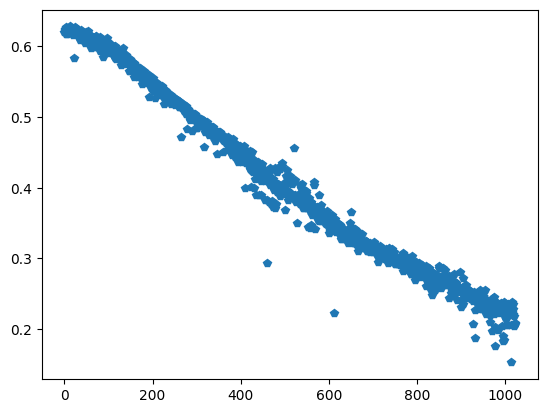

In [13]:
plt.plot(range(len(proportions_in_times)), [prop[0] for prop in proportions_in_times], 'p')

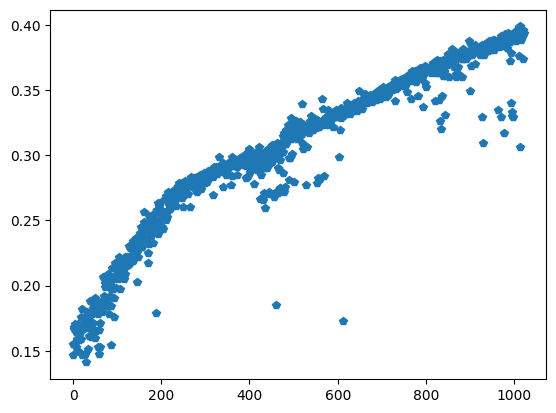

In [14]:
plt.plot(range(len(proportions_in_times)), [prop[1] for prop in proportions_in_times], 'p')

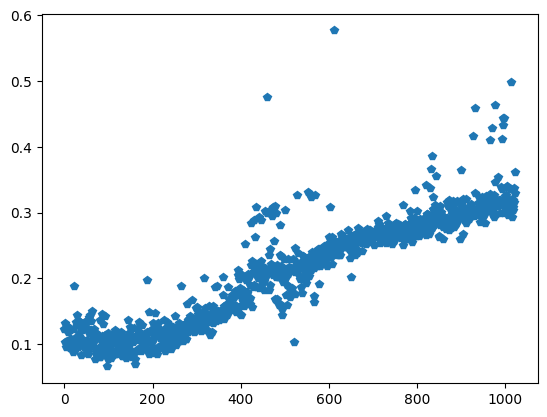

In [15]:
plt.plot(range(len(proportions_in_times)), [prop[2] for prop in proportions_in_times], 'p')

In [16]:
with open('results/sacharose_1000/comparing_with_first/known_substrats/proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(proportions_in_times, f)

In [17]:
with open('results/sacharose_1000/comparing_with_first/known_substrats/noise_proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_proportions_in_times, f)

### Linear regression

In [18]:
with open(r'results/sacharose_1000/comparing_with_first/known_substrats/proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y).reshape(-1,1)

In [19]:
t = np.array(range(1,1024))
t_and_ones = np.vstack([t, np.ones(len(t))]).T

In [22]:
slope, intercept = np.linalg.lstsq(t_and_ones, y)[0]

/tmp/ipykernel_3869/1288480160.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope, intercept = np.linalg.lstsq(t_and_ones, y)[0]


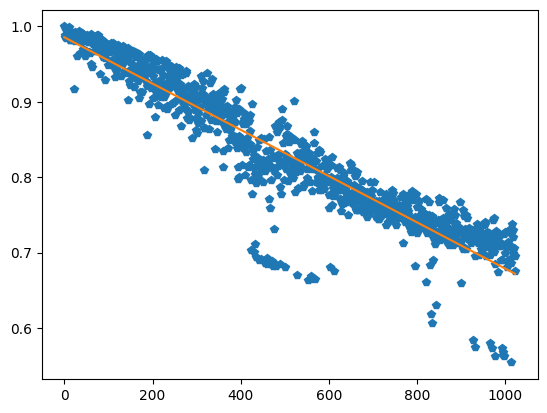

In [23]:
plt.plot(range(len(y)), [prop[0] for prop in y], 'p')
plt.plot(slope*t+intercept)